Oxford-IIIT Pet Dataset - Exploratory Data Analysis
Focus: Transfer Learning with Pre-trained CNNs

[1] LOADING DATASET...
 Loaded 7390 images
 Found 37 unique breeds
 Species distribution: {'dog': 4990, 'cat': 2400}

[2] DATA QUALITY CHECKS...


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Valid images: 7390
Corrupted/unreadable: 0
Color images (3 channels): 7390
Grayscale images (1 channel): 0

Image Resolution Statistics:
  Width range: 114 - 3264 px
  Height range: 103 - 2606 px
  Average dimensions: 437 x 391 px
  File size range: 3.3 - 1098.8 KB

[3] CLASS DISTRIBUTION ANALYSIS...

 Dataset Composition:
  • Total breeds: 37
  • Images per breed (avg): 199.7
  • Images per breed (min): 191
  • Images per breed (max): 200
  • Class imbalance ratio: 1.05x

 Cats: 2400 images (32.5%)
 Dogs: 4990 images (67.5%)

[4] ANALYZING IMAGE CHARACTERISTICS...

 Aspect Ratio Distribution:
  • Landscape (wider): 4902 (66.3%)
  • Portrait (taller): 2372 (32.1%)
  • Square: 116 (1.6%)

[5] GENERATING VISUALIZATIONS...


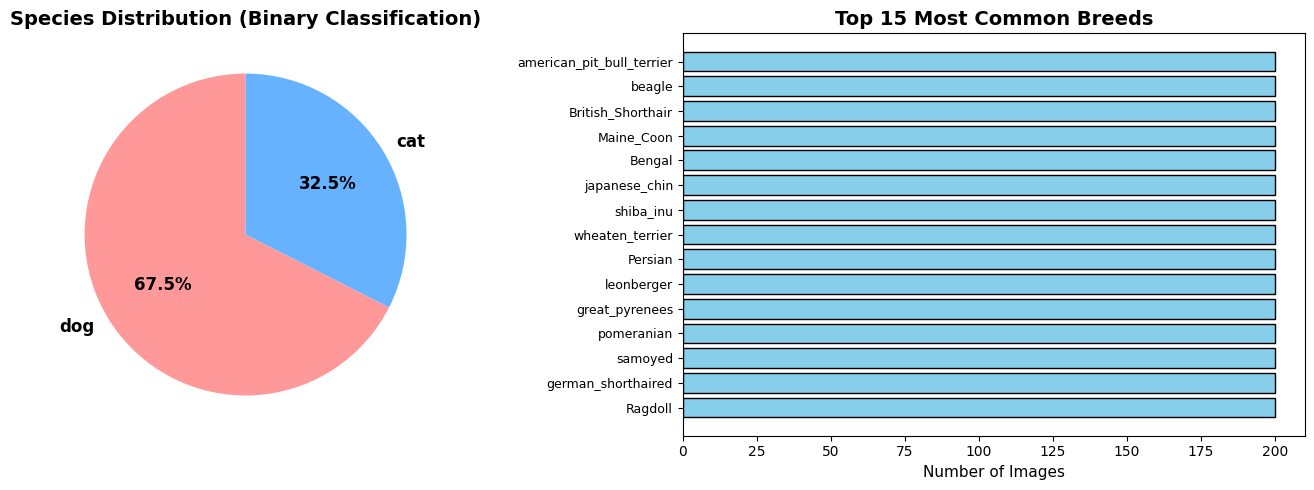

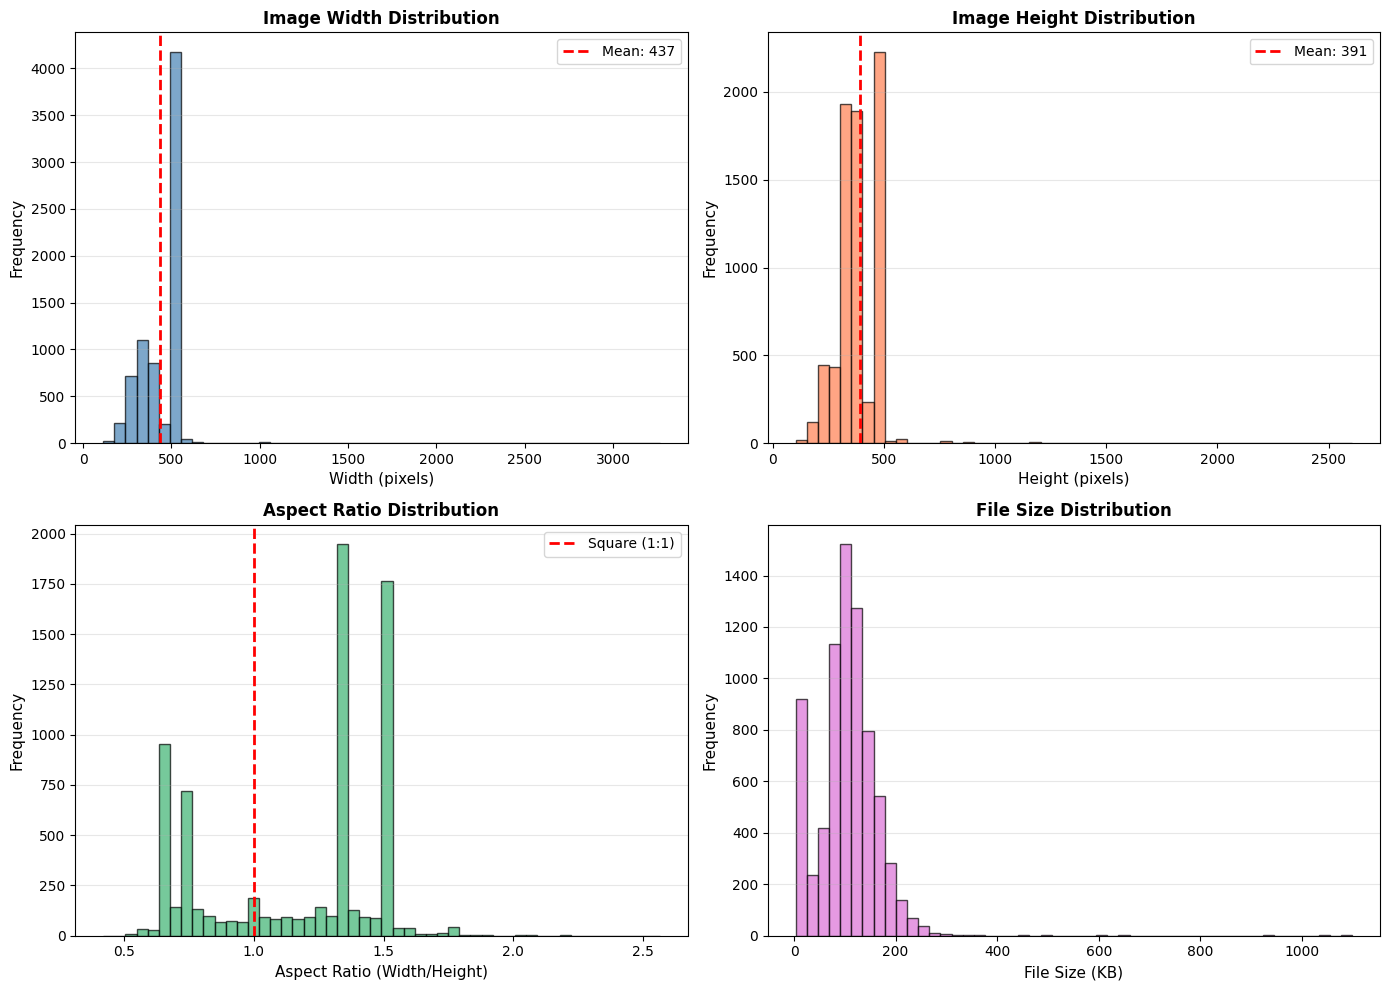

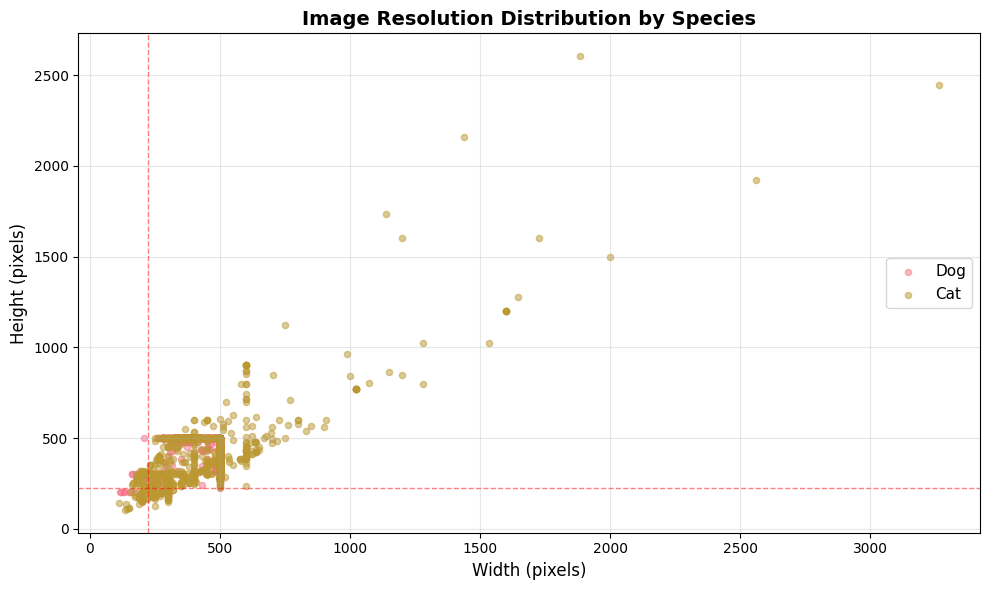


[6] CREATING SAMPLE IMAGE GRID...


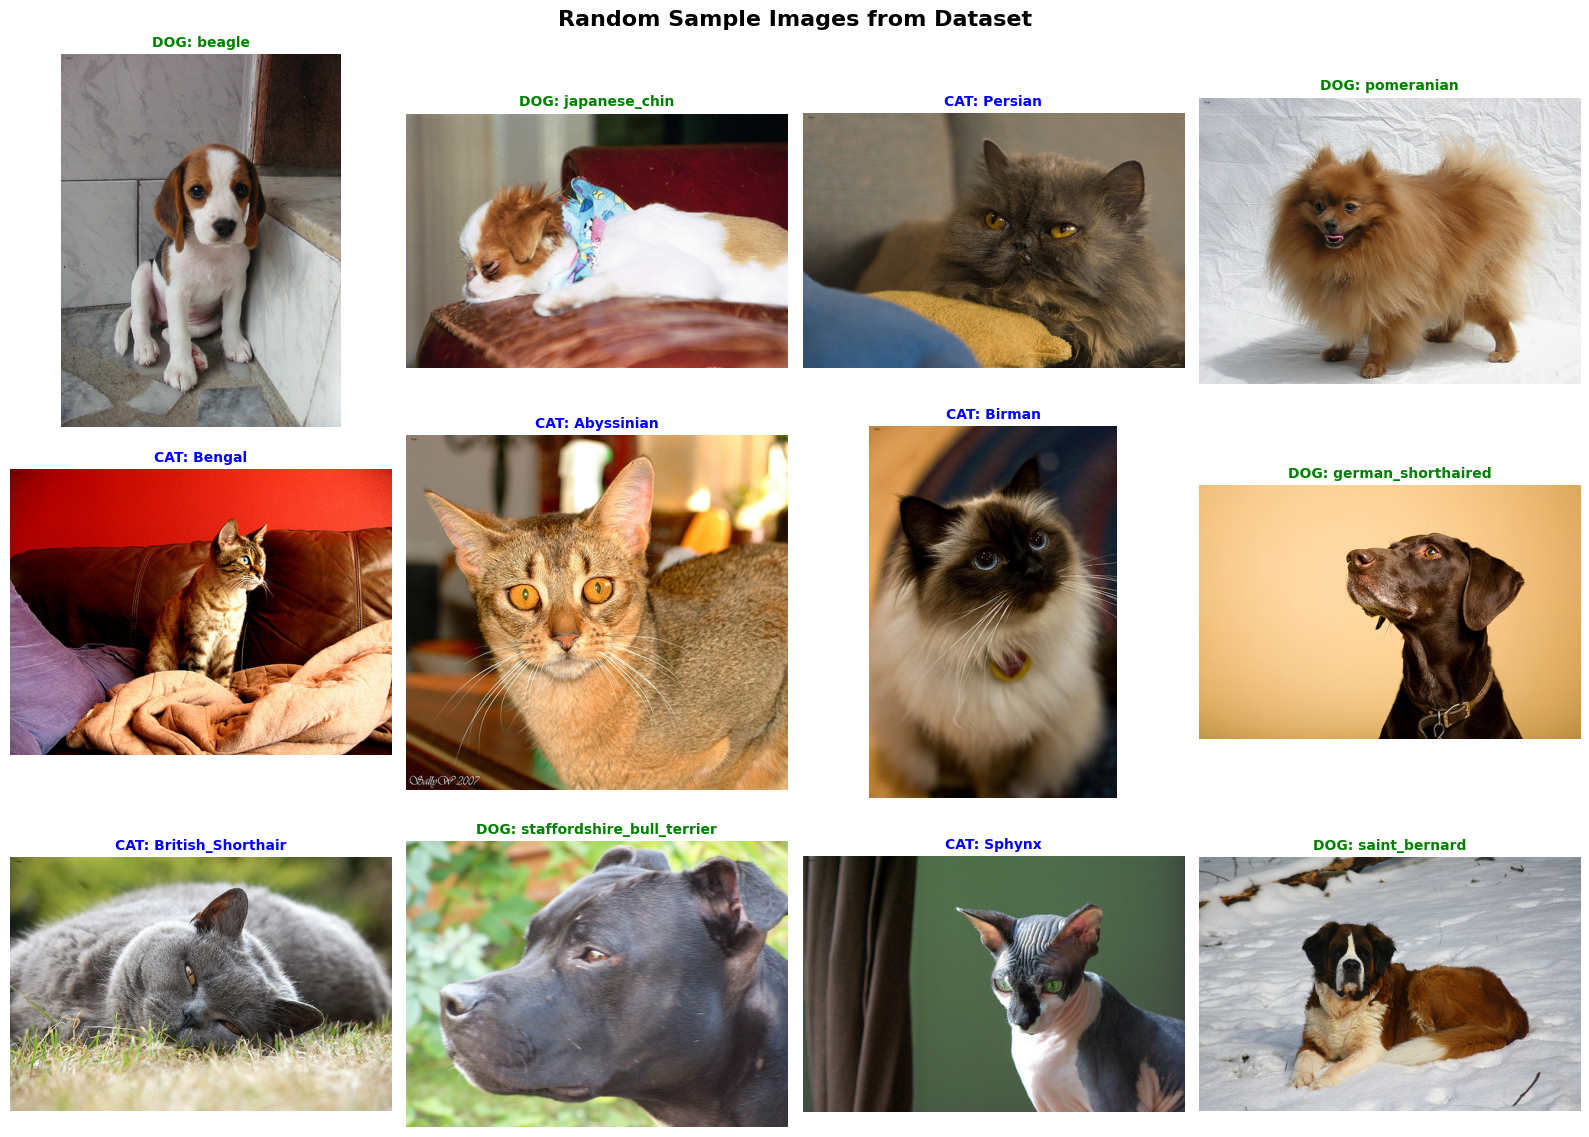


PREPROCESSING RECOMMENDATIONS FOR TRANSFER LEARNING

 Key Findings:
  • Dataset is reasonably balanced between cats and dogs
  • Image sizes vary significantly (needs standardization)
  • Target resize: 224x224 pixels (standard for ImageNet pre-trained models)
  • All images are RGB (3 channels) - suitable for CNN input

 Recommended Preprocessing Pipeline:
  1. Resize all images to 224x224 pixels
  2. Normalize using ImageNet statistics:
     - Mean: [0.485, 0.456, 0.406]
     - Std:  [0.229, 0.224, 0.225]
  3. Apply data augmentation:
     - Random horizontal flip
     - Random rotation (±15 degrees)
     - Random zoom (0.8-1.2)
     - Random brightness/contrast adjustment

 Train/Validation/Test Split Recommendation:
  • Training: 70% (~5,200 images)
  • Validation: 15% (~1,100 images)
  • Testing: 15% (~1,100 images)
  • Use stratified split to maintain class balance

 Dataset is ready for transfer learning with:
  • ResNet50
  • EfficientNetB0
  • MobileNetV2

[7] GENERATING SUMM

In [3]:
# ================================================================
# EDA: Oxford-IIIT Pet Dataset for Transfer Learning
# Project: Applying Transfer Learning for Image Classification
# Focus: Data Exploration and Preprocessing for CNN Transfer Learning
# ================================================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
from PIL import Image
import random

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Visualization style
plt.style.use('default')
sns.set_palette("husl")

print("=" * 60)
print("Oxford-IIIT Pet Dataset - Exploratory Data Analysis")
print("Focus: Transfer Learning with Pre-trained CNNs")
print("=" * 60)

# ================================================================
# SECTION 1: DATASET LOADING AND INITIAL EXPLORATION
# ================================================================

print("\n[1] LOADING DATASET...")

# Dataset paths (Kaggle structure)
BASE_PATH = "/kaggle/input/oxford-pet-dataset/oxford-iiit-pet"
IMAGES_PATH = os.path.join(BASE_PATH, "images", "images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations", "annotations")

# Load the dataset information
def load_dataset_info():
    """Load image paths and extract breed/species information"""
    image_data = []
    
    if not os.path.exists(IMAGES_PATH):
        print(f"ERROR: Path not found: {IMAGES_PATH}")
        return pd.DataFrame()
    
    for img_file in os.listdir(IMAGES_PATH):
        if img_file.endswith(('.jpg', '.png')):
            img_path = os.path.join(IMAGES_PATH, img_file)
            
            # Extract breed name (everything before the last underscore and number)
            parts = img_file.split('.')[0].split('_')
            breed_name = '_'.join(parts[:-1])
            
            # Determine species (cat or dog) - capitalize first letter indicates cat
            species = 'cat' if breed_name[0].isupper() else 'dog'
            
            image_data.append({
                'filename': img_file,
                'filepath': img_path,
                'breed': breed_name,
                'species': species
            })
    
    return pd.DataFrame(image_data)

df = load_dataset_info()

if df.empty:
    print("ERROR: No data loaded. Check dataset path.")
else:
    print(f" Loaded {len(df)} images")
    print(f" Found {df['breed'].nunique()} unique breeds")
    print(f" Species distribution: {df['species'].value_counts().to_dict()}")

# ================================================================
# SECTION 2: DATA QUALITY AND INTEGRITY CHECKS
# ================================================================

print("\n[2] DATA QUALITY CHECKS...")

def check_data_quality(df):
    """Perform comprehensive data quality checks"""
    
    corrupted = []
    image_properties = []
    
    for idx, row in df.iterrows():
        try:
            # Try to open and read image
            img = cv2.imread(row['filepath'])
            
            if img is None:
                corrupted.append(row['filename'])
                continue
            
            # Get image properties
            height, width, channels = img.shape
            file_size = os.path.getsize(row['filepath']) / 1024  # KB
            
            image_properties.append({
                'filename': row['filename'],
                'filepath': row['filepath'],
                'breed': row['breed'],
                'species': row['species'],
                'height': height,
                'width': width,
                'channels': channels,
                'file_size_kb': file_size,
                'aspect_ratio': width / height
            })
            
        except Exception as e:
            corrupted.append(row['filename'])
    
    properties_df = pd.DataFrame(image_properties)
    
    return properties_df, corrupted

properties_df, corrupted_files = check_data_quality(df)

# Quality report
print(f"\nValid images: {len(properties_df)}")
print(f"Corrupted/unreadable: {len(corrupted_files)}")
print(f"Color images (3 channels): {(properties_df['channels'] == 3).sum()}")
print(f"Grayscale images (1 channel): {(properties_df['channels'] == 1).sum()}")

# Resolution statistics
print(f"\nImage Resolution Statistics:")
print(f"  Width range: {properties_df['width'].min()} - {properties_df['width'].max()} px")
print(f"  Height range: {properties_df['height'].min()} - {properties_df['height'].max()} px")
print(f"  Average dimensions: {properties_df['width'].mean():.0f} x {properties_df['height'].mean():.0f} px")
print(f"  File size range: {properties_df['file_size_kb'].min():.1f} - {properties_df['file_size_kb'].max():.1f} KB")

# ================================================================
# SECTION 3: CLASS DISTRIBUTION ANALYSIS
# ================================================================

print("\n[3] CLASS DISTRIBUTION ANALYSIS...")

# Breed distribution
breed_counts = properties_df['breed'].value_counts()
species_counts = properties_df['species'].value_counts()

print(f"\n Dataset Composition:")
print(f"  • Total breeds: {len(breed_counts)}")
print(f"  • Images per breed (avg): {breed_counts.mean():.1f}")
print(f"  • Images per breed (min): {breed_counts.min()}")
print(f"  • Images per breed (max): {breed_counts.max()}")

# Check class balance
imbalance_ratio = breed_counts.max() / breed_counts.min()
print(f"  • Class imbalance ratio: {imbalance_ratio:.2f}x")

# Species balance
print(f"\n Cats: {species_counts.get('cat', 0)} images ({species_counts.get('cat', 0)/len(properties_df)*100:.1f}%)")
print(f" Dogs: {species_counts.get('dog', 0)} images ({species_counts.get('dog', 0)/len(properties_df)*100:.1f}%)")

# ================================================================
# SECTION 4: VISUAL ANALYSIS - IMAGE PROPERTIES
# ================================================================

print("\n[4] ANALYZING IMAGE CHARACTERISTICS...")

# Calculate additional statistics
properties_df['total_pixels'] = properties_df['width'] * properties_df['height']

# Aspect ratio analysis
landscape = (properties_df['aspect_ratio'] > 1).sum()
portrait = (properties_df['aspect_ratio'] < 1).sum()
square = (properties_df['aspect_ratio'] == 1).sum()

print(f"\n Aspect Ratio Distribution:")
print(f"  • Landscape (wider): {landscape} ({landscape/len(properties_df)*100:.1f}%)")
print(f"  • Portrait (taller): {portrait} ({portrait/len(properties_df)*100:.1f}%)")
print(f"  • Square: {square} ({square/len(properties_df)*100:.1f}%)")

# ================================================================
# SECTION 5: VISUALIZATIONS
# ================================================================

print("\n[5] GENERATING VISUALIZATIONS...")

# Figure 1: Species Distribution (Pie Chart)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Species pie chart
species_data = properties_df['species'].value_counts()
colors_species = ['#FF9999', '#66B2FF']
axes[0].pie(species_data, labels=species_data.index, autopct='%1.1f%%', 
            startangle=90, colors=colors_species, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0].set_title('Species Distribution (Binary Classification)', fontsize=14, weight='bold')

# Top 15 breeds bar chart
top_breeds = breed_counts.head(15)
axes[1].barh(range(len(top_breeds)), top_breeds.values, color='skyblue', edgecolor='black')
axes[1].set_yticks(range(len(top_breeds)))
axes[1].set_yticklabels(top_breeds.index, fontsize=9)
axes[1].set_xlabel('Number of Images', fontsize=11)
axes[1].set_title('Top 15 Most Common Breeds', fontsize=14, weight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('figure1_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Figure 2: Image Dimensions Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Width distribution
axes[0, 0].hist(properties_df['width'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(properties_df['width'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {properties_df["width"].mean():.0f}')
axes[0, 0].set_xlabel('Width (pixels)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Image Width Distribution', fontsize=12, weight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Height distribution
axes[0, 1].hist(properties_df['height'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(properties_df['height'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {properties_df["height"].mean():.0f}')
axes[0, 1].set_xlabel('Height (pixels)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Image Height Distribution', fontsize=12, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Aspect ratio distribution
axes[1, 0].hist(properties_df['aspect_ratio'], bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Square (1:1)')
axes[1, 0].set_xlabel('Aspect Ratio (Width/Height)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=12, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# File size distribution
axes[1, 1].hist(properties_df['file_size_kb'], bins=50, color='orchid', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('File Size (KB)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('File Size Distribution', fontsize=12, weight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure2_image_properties.png', dpi=150, bbox_inches='tight')
plt.show()

# Figure 3: Resolution Scatter Plot
fig, ax = plt.subplots(figsize=(10, 6))

for species in properties_df['species'].unique():
    species_data = properties_df[properties_df['species'] == species]
    ax.scatter(species_data['width'], species_data['height'], 
               label=species.capitalize(), alpha=0.5, s=20)

ax.set_xlabel('Width (pixels)', fontsize=12)
ax.set_ylabel('Height (pixels)', fontsize=12)
ax.set_title('Image Resolution Distribution by Species', fontsize=14, weight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Add reference line for 224x224 (typical CNN input)
ax.axhline(224, color='red', linestyle='--', alpha=0.5, linewidth=1, label='224px (CNN target)')
ax.axvline(224, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.savefig('figure3_resolution_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

# Figure 4: Sample Images Grid
print("\n[6] CREATING SAMPLE IMAGE GRID...")

def show_sample_images(df, n_samples=12):
    """Display random sample images from each species"""
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    # Get balanced samples from each species
    cats = df[df['species'] == 'cat'].sample(n=n_samples//2, random_state=SEED)
    dogs = df[df['species'] == 'dog'].sample(n=n_samples//2, random_state=SEED)
    samples = pd.concat([cats, dogs]).sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        if idx >= n_samples:
            break
            
        img = cv2.imread(row['filepath'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"{row['species'].upper()}: {row['breed']}", 
                           fontsize=10, weight='bold', 
                           color='blue' if row['species']=='cat' else 'green')
        axes[idx].axis('off')
    
    plt.suptitle('Random Sample Images from Dataset', fontsize=16, weight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('figure4_sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

show_sample_images(properties_df, n_samples=12)

# ================================================================
# SECTION 6: PREPROCESSING RECOMMENDATIONS FOR TRANSFER LEARNING
# ================================================================

print("\n" + "=" * 60)
print("PREPROCESSING RECOMMENDATIONS FOR TRANSFER LEARNING")
print("=" * 60)

print("\n Key Findings:")
print(f"  • Dataset is reasonably balanced between cats and dogs")
print(f"  • Image sizes vary significantly (needs standardization)")
print(f"  • Target resize: 224x224 pixels (standard for ImageNet pre-trained models)")
print(f"  • All images are RGB (3 channels) - suitable for CNN input")

print("\n Recommended Preprocessing Pipeline:")
print("  1. Resize all images to 224x224 pixels")
print("  2. Normalize using ImageNet statistics:")
print("     - Mean: [0.485, 0.456, 0.406]")
print("     - Std:  [0.229, 0.224, 0.225]")
print("  3. Apply data augmentation:")
print("     - Random horizontal flip")
print("     - Random rotation (±15 degrees)")
print("     - Random zoom (0.8-1.2)")
print("     - Random brightness/contrast adjustment")

print("\n Train/Validation/Test Split Recommendation:")
print("  • Training: 70% (~5,200 images)")
print("  • Validation: 15% (~1,100 images)")
print("  • Testing: 15% (~1,100 images)")
print("  • Use stratified split to maintain class balance")

print("\n Dataset is ready for transfer learning with:")
print("  • ResNet50")
print("  • EfficientNetB0")
print("  • MobileNetV2")

# ================================================================
# SECTION 7: SUMMARY STATISTICS TABLE
# ================================================================

print("\n[7] GENERATING SUMMARY STATISTICS...")

summary_stats = pd.DataFrame({
    'Metric': [
        'Total Images',
        'Number of Breeds',
        'Number of Species',
        'Average Width (px)',
        'Average Height (px)',
        'Avg Aspect Ratio',
        'Avg File Size (KB)',
        'Min Images per Breed',
        'Max Images per Breed',
        'Class Imbalance Ratio'
    ],
    'Value': [
        len(properties_df),
        properties_df['breed'].nunique(),
        properties_df['species'].nunique(),
        f"{properties_df['width'].mean():.0f}",
        f"{properties_df['height'].mean():.0f}",
        f"{properties_df['aspect_ratio'].mean():.2f}",
        f"{properties_df['file_size_kb'].mean():.1f}",
        breed_counts.min(),
        breed_counts.max(),
        f"{imbalance_ratio:.2f}x"
    ]
})

print("\n Dataset Summary Statistics:")
print(summary_stats.to_string(index=False))

# Save summary to CSV
properties_df.to_csv('oxford_pet_properties.csv', index=False)
summary_stats.to_csv('dataset_summary.csv', index=False)

print("\n" + "=" * 60)
print("EDA COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("\n All visualizations saved")
print(" Dataset properties exported to CSV")
print(" Ready for transfer learning implementation")
print("\nNext Steps:")
print("  - Implement train/val/test split")
print("  - Build data pipeline with augmentation")
print("  - Fine-tune pre-trained models")
print("=" * 60)